# **Nâng cao Keras**
> Tương tự như fastai, chúng ta sẽ cùng thử với một vài phương pháp train dữ liệu như:
> 1. Progressive Resize
> 2. TTA
> 3. MixUP
> 4. LabelSmooth

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing as PreprocessingLayers
from tensorflow.keras import backend as bk
import numpy as np
import math

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Kiểm tra GPU:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Kiểm tra tensorflow & keras version:
tf.__version__, keras.__version__

('2.4.1', '2.4.0')

In [ ]:
# Tạo path dữ liệu:
path = '../data'
!ls {path}

test  train


# Giới hạn GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
!nvidia-smi

Mon Sep  6 11:08:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.01    Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 38%   43C    P8    16W / 180W |    921MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tạo dữ liệu

In [ ]:
# Tạo dữ liệu
def create_raw_ds():
    bs = 32
    seed = 42
    train_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='training'
    )

    valid_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='validation'
    )
    return train_ds, valid_ds

In [ ]:
# Tạo preprocessing layer:
def create_preprocessed_ds(dataset, size):
    preprocessing_layer = keras.Sequential([
        PreprocessingLayers.RandomCrop(size, size, seed=42),
        PreprocessingLayers.RandomContrast([.5, 1.5]),
        PreprocessingLayers.RandomFlip(),
        keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
    ])

    def preprocess_images(image, label):
        image = preprocessing_layer(image)
        return image, label
    
    dataset = dataset.map(preprocess_images)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def f1(y_true, y_pred):
    # Tính True Positive:
    TP = bk.sum(bk.round(bk.clip(y_true * y_pred, 0, 1)))
    
    # Tính Actual Positve: TP + FN
    TP_FN = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    
    # Tính Predicted Positve: TP + FP
    TP_FP = bk.sum(bk.round(bk.clip(y_pred, 0, 1)))
    
    return  (2 * TP)/(TP_FN + TP_FP + bk.epsilon())

In [ ]:
# Tạo hàm tạo model:
def create_model(size: int, num_classes: int=1):
    activation = 'sigmoid'
    if num_classes > 2: activation='softmax'
    resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3))
    for layer in resnet_model.layers:
        layer.trainable=False
    
    flatten = keras.layers.Flatten()(resnet_model.output)
    # Bổ sung dropout layer:
    dropout = keras.layers.Dropout(.5)(flatten)
    prediction = keras.layers.Dense(num_classes, activation=activation)(dropout)
    return keras.models.Model(inputs=resnet_model.input, outputs=prediction)

# Progressive Resize
> Chúng ta sẽ thử với 3 size khác nhau: 128, 224 và 256. Với mỗi inputshape này, chúng ta sẽ phải tạo mới model, tuy nhiên, sẽ update weights của layer cuối cùng từ model cũ.

## SIZE 128

In [ ]:
SIZE = 128

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
def record_lr(model, epoch, train_ds, valid_ds):
    lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch/5)))
    optimizer = keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
    model.fit(train_ds, epochs=epoch, validation_data=valid_ds, callbacks=[lr_scheduler])

In [ ]:
bk.clear_session()
model = create_model(SIZE, 1)
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 4s 114ms/step - loss: 1.7318 - accuracy: 0.5766 - f1: 0.6337 - val_loss: 1.5156 - val_accuracy: 0.5141 - val_f1: 0.6108
Epoch 2/40
18/18 [==============================] - 1s 62ms/step - loss: 2.0812 - accuracy: 0.4904 - f1: 0.5617 - val_loss: 1.5155 - val_accuracy: 0.5141 - val_f1: 0.6108
Epoch 3/40
18/18 [==============================] - 1s 77ms/step - loss: 1.9433 - accuracy: 0.5017 - f1: 0.5699 - val_loss: 1.5154 - val_accuracy: 0.5141 - val_f1: 0.6108
Epoch 4/40
18/18 [==============================] - 1s 66ms/step - loss: 1.9723 - accuracy: 0.5040 - f1: 0.5654 - val_loss: 1.5152 - val_accuracy: 0.5141 - val_f1: 0.6108
Epoch 5/40
18/18 [==============================] - 1s 67ms/step - loss: 1.8087 - accuracy: 0.5036 - f1: 0.5679 - val_loss: 1.5148 - val_accuracy: 0.5141 - val_f1: 0.6108
Epoch 6/40
18/18 [==============================] - 1s 68ms/step - loss: 1.8288 - accuracy: 0.5311 - f1: 0.5855 - val_loss: 1.5142 - val_accurac

In [ ]:
def plot_lr(history):
    plt.figure(figsize=(8,4))
    plt.semilogx(history["lr"], history["loss"])
    plt.axis([1e-8, 1e-1, 0, 2])
    plt.show()

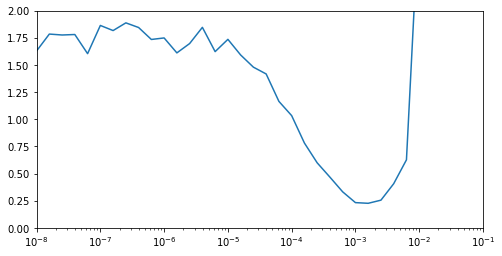

In [ ]:
plot_lr(model.history.history)

In [ ]:
def find_lr(history):
    lr_list = history['lr']
    loss_list = history['loss']
    empty_dict = {}
    for i in range(len(lr_list)):
        if (loss_list[i] <= 2) & (lr_list[i] <= 1e-1) & (i >= 1):
            empty_dict.update({lr_list[i]: loss_list[i-1] - loss_list[i]})
    max_gap = max(empty_dict.values())
    for key in empty_dict.keys():
        if empty_dict[key] == max_gap: print("max_lr =", key)
    return empty_dict

In [ ]:
lr_list = find_lr(model.history.history)
lr_list

max_lr = 6.309574e-05


{1.5848931e-08: -0.15541160106658936,
 2.5118863e-08: 0.008539319038391113,
 3.981072e-08: -0.0044116973876953125,
 6.309573e-08: 0.17613482475280762,
 1e-07: -0.25949597358703613,
 1.5848931e-07: 0.0470273494720459,
 2.5118865e-07: -0.07088792324066162,
 3.9810718e-07: 0.04282355308532715,
 6.3095735e-07: 0.10992586612701416,
 1e-06: -0.01399385929107666,
 1.5848932e-06: 0.13748204708099365,
 2.5118864e-06: -0.08585989475250244,
 3.9810716e-06: -0.1490931510925293,
 6.3095736e-06: 0.22330987453460693,
 1e-05: -0.11289477348327637,
 1.5848931e-05: 0.1436612606048584,
 2.5118865e-05: 0.11215436458587646,
 3.981072e-05: 0.06249392032623291,
 6.309574e-05: 0.2522691488265991,
 1e-04: 0.1310100555419922,
 0.00015848932: 0.2520580291748047,
 0.00025118864: 0.18199437856674194,
 0.00039810716: 0.13176584243774414,
 0.00063095737: 0.13518449664115906,
 0.001: 0.09912355244159698,
 0.0015848932: 0.006240144371986389,
 0.0025118864: -0.028782755136489868,
 0.0039810715: -0.15136554837226868,
 0

### Bắt đầu lại

In [ ]:
def lr_cycle(epoch, max_lr):
    stepsize = 4
    epsilon = math.log(10, stepsize)
    remainder = epoch % (stepsize * 2)
    if (stepsize + 1) <= remainder: new_lr = max_lr * (epsilon ** (remainder - stepsize - 1))
    else: new_lr = max_lr / (epsilon ** (remainder - stepsize - 1))
    return new_lr

In [ ]:
max_lr = 6.309574e-05
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/24
18/18 [==============================] - 5s 114ms/step - loss: 1.9046 - accuracy: 0.5710 - f1: 0.5938 - val_loss: 1.0626 - val_accuracy: 0.7042 - val_f1: 0.7251
Epoch 2/24
18/18 [==============================] - 1s 66ms/step - loss: 0.6395 - accuracy: 0.8297 - f1: 0.8381 - val_loss: 0.8487 - val_accuracy: 0.7465 - val_f1: 0.7490
Epoch 3/24
18/18 [==============================] - 1s 63ms/step - loss: 0.2963 - accuracy: 0.9081 - f1: 0.9168 - val_loss: 0.8813 - val_accuracy: 0.7676 - val_f1: 0.7818
Epoch 4/24
18/18 [==============================] - 1s 61ms/step - loss: 0.2541 - accuracy: 0.9167 - f1: 0.9175 - val_loss: 0.8802 - val_accuracy: 0.7746 - val_f1: 0.7856
Epoch 5/24
18/18 [==============================] - 1s 62ms/step - loss: 0.2128 - accuracy: 0.9087 - f1: 0.9146 - val_loss: 0.9865 - val_accuracy: 0.7817 - val_f1: 0.8080
Epoch 6/24
18/18 [==============================] - 1s 63ms/step - loss: 0.1691 - accuracy: 0.9272 - f1: 0.9355 - val_loss: 0.8964 - val_accurac

In [ ]:
# Save model:
save_path = "/mnt/d/practice/projects/swift_swallow/models/"
model.save(f'{save_path}/keras_PR_128')

INFO:tensorflow:Assets written to: /mnt/d/practice/projects/swift_swallow/models//keras_PR_128/assets


In [ ]:
# Lấy toàn bộ weights của layer cuối cùng (prediction)
last_layer_weights_128 = model.layers[len(model.layers)-1].get_weights()
last_layer_weights_128

[array([[ 0.00720141],
        [-0.00967764],
        [-0.00890184],
        ...,
        [ 0.00686435],
        [ 0.00777911],
        [ 0.01045314]], dtype=float32),
 array([0.00352285], dtype=float32)]

## SIZE 224

In [ ]:
SIZE = 224

### Tạo lại dữ liệu

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Cập nhật model
> Chúng ta cần cập nhật layer cuối cùng của model mới, dựa vào weights của model cũ.

In [ ]:
def update_model(model, weights):
    update_len = [len(weights[0]), len(weights[1])]
    idx = len(model.layers) - 1
    last_weights = model.layers[idx].get_weights()
    
    # Cập nhật weights:
    for i in [0, 1]:
        np.put(last_weights[i], np.arange(update_len[i]),  weights[i])
    
    # bổ sung weights vào model:
    model.layers[idx].set_weights(last_weights)

### Tìm lr

In [ ]:
bk.clear_session()
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_128)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 9s 307ms/step - loss: 1.2767 - accuracy: 0.6828 - f1: 0.7096 - val_loss: 0.8310 - val_accuracy: 0.7746 - val_f1: 0.8124
Epoch 2/40
18/18 [==============================] - 2s 136ms/step - loss: 1.3855 - accuracy: 0.6826 - f1: 0.7128 - val_loss: 0.8309 - val_accuracy: 0.7746 - val_f1: 0.8124
Epoch 3/40
18/18 [==============================] - 2s 125ms/step - loss: 1.1639 - accuracy: 0.6747 - f1: 0.6824 - val_loss: 0.8309 - val_accuracy: 0.7746 - val_f1: 0.8124
Epoch 4/40
18/18 [==============================] - 2s 123ms/step - loss: 1.2774 - accuracy: 0.7008 - f1: 0.7188 - val_loss: 0.8308 - val_accuracy: 0.7746 - val_f1: 0.8124
Epoch 5/40
18/18 [==============================] - 2s 123ms/step - loss: 1.3729 - accuracy: 0.6698 - f1: 0.6899 - val_loss: 0.8306 - val_accuracy: 0.7746 - val_f1: 0.8124
Epoch 6/40
18/18 [==============================] - 2s 123ms/step - loss: 1.4261 - accuracy: 0.6819 - f1: 0.7008 - val_loss: 0.8302 - val_ac

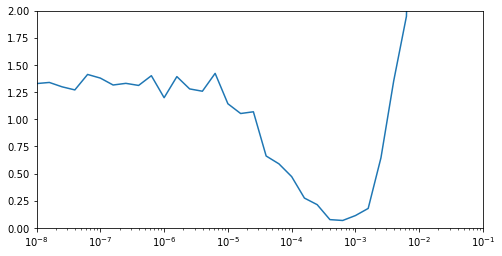

In [ ]:
plot_lr(model.history.history)

In [ ]:
lr_list = find_lr(model.history.history)
lr_list

max_lr = 3.981072e-05


{1.5848931e-08: -0.010412454605102539,
 2.5118863e-08: 0.040226101875305176,
 3.981072e-08: 0.028507351875305176,
 6.309573e-08: -0.14230382442474365,
 1e-07: 0.03351271152496338,
 1.5848931e-07: 0.06360673904418945,
 2.5118865e-07: -0.015206694602966309,
 3.9810718e-07: 0.01910233497619629,
 6.3095735e-07: -0.08945679664611816,
 1e-06: 0.20239830017089844,
 1.5848932e-06: -0.19408035278320312,
 2.5118864e-06: 0.11313951015472412,
 3.9810716e-06: 0.021314144134521484,
 6.3095736e-06: -0.16432785987854004,
 1e-05: 0.2795701026916504,
 1.5848931e-05: 0.0897667407989502,
 2.5118865e-05: -0.01593160629272461,
 3.981072e-05: 0.4067336320877075,
 6.309574e-05: 0.07194381952285767,
 1e-04: 0.11764213442802429,
 0.00015848932: 0.1973070502281189,
 0.00025118864: 0.06058673560619354,
 0.00039810716: 0.13773063570261002,
 0.00063095737: 0.007844984531402588,
 0.001: -0.045226626098155975,
 0.0015848932: -0.06555844843387604,
 0.0025118864: -0.4651540368795395,
 0.0039810715: -0.7072306275367737,

### Bắt đầu lại

In [ ]:
max_lr = 3.981072e-05
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_128)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/24
18/18 [==============================] - 6s 182ms/step - loss: 1.8057 - accuracy: 0.6893 - f1: 0.7085 - val_loss: 2.4653 - val_accuracy: 0.6972 - val_f1: 0.7766
Epoch 2/24
18/18 [==============================] - 2s 122ms/step - loss: 0.9171 - accuracy: 0.8468 - f1: 0.8650 - val_loss: 1.0984 - val_accuracy: 0.8310 - val_f1: 0.8530
Epoch 3/24
18/18 [==============================] - 2s 123ms/step - loss: 0.0868 - accuracy: 0.9724 - f1: 0.9736 - val_loss: 1.1691 - val_accuracy: 0.8380 - val_f1: 0.8575
Epoch 4/24
18/18 [==============================] - 2s 122ms/step - loss: 0.0422 - accuracy: 0.9895 - f1: 0.9898 - val_loss: 1.1467 - val_accuracy: 0.8310 - val_f1: 0.8530
Epoch 5/24
18/18 [==============================] - 2s 122ms/step - loss: 0.0167 - accuracy: 0.9937 - f1: 0.9941 - val_loss: 1.1302 - val_accuracy: 0.8310 - val_f1: 0.8530
Epoch 6/24
18/18 [==============================] - 2s 123ms/step - loss: 0.0215 - accuracy: 0.9873 - f1: 0.9863 - val_loss: 1.1024 - val_ac

In [ ]:
model.save(f'{save_path}/keras_PR_224')

INFO:tensorflow:Assets written to: /mnt/d/practice/projects/swift_swallow/models//keras_PR_224/assets


In [ ]:
last_layer_weights_224 = model.layers[len(model.layers)-1].get_weights()

## SIZE 256

In [ ]:
SIZE = 256

### Tạo lại dữ liệu

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
bk.clear_session()
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_224)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 6s 204ms/step - loss: 0.8921 - accuracy: 0.8535 - f1: 0.8690 - val_loss: 1.3738 - val_accuracy: 0.8169 - val_f1: 0.8540
Epoch 2/40
18/18 [==============================] - 3s 152ms/step - loss: 0.9117 - accuracy: 0.8362 - f1: 0.8532 - val_loss: 1.3737 - val_accuracy: 0.8169 - val_f1: 0.8540
Epoch 3/40
18/18 [==============================] - 3s 150ms/step - loss: 0.9357 - accuracy: 0.8275 - f1: 0.8413 - val_loss: 1.3736 - val_accuracy: 0.8169 - val_f1: 0.8540
Epoch 4/40
18/18 [==============================] - 3s 150ms/step - loss: 0.8218 - accuracy: 0.8518 - f1: 0.8631 - val_loss: 1.3735 - val_accuracy: 0.8169 - val_f1: 0.8540
Epoch 5/40
18/18 [==============================] - 3s 149ms/step - loss: 0.9197 - accuracy: 0.8419 - f1: 0.8544 - val_loss: 1.3733 - val_accuracy: 0.8169 - val_f1: 0.8540
Epoch 6/40
18/18 [==============================] - 3s 149ms/step - loss: 1.0573 - accuracy: 0.8361 - f1: 0.8531 - val_loss: 1.3728 - val_ac

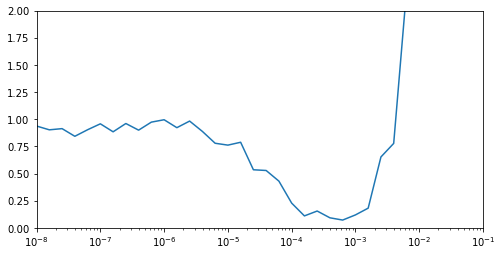

In [ ]:
plot_lr(model.history.history)

In [ ]:
find_lr(model.history.history)

max_lr = 2.5118865e-05


{1.5848931e-08: 0.034744083881378174,
 2.5118863e-08: -0.01087963581085205,
 3.981072e-08: 0.07042890787124634,
 6.309573e-08: -0.060292065143585205,
 1e-07: -0.054490089416503906,
 1.5848931e-07: 0.07347142696380615,
 2.5118865e-07: -0.07621949911117554,
 3.9810718e-07: 0.060922861099243164,
 6.3095735e-07: -0.07373112440109253,
 1e-06: -0.02190631628036499,
 1.5848932e-06: 0.07296448945999146,
 2.5118864e-06: -0.06068497896194458,
 3.9810716e-06: 0.09501045942306519,
 6.3095736e-06: 0.10894542932510376,
 1e-05: 0.01722562313079834,
 1.5848931e-05: -0.02636617422103882,
 2.5118865e-05: 0.253052294254303,
 3.981072e-05: 0.006566107273101807,
 6.309574e-05: 0.09794580936431885,
 1e-04: 0.20213523507118225,
 0.00015848932: 0.11759083718061447,
 0.00025118864: -0.04473546892404556,
 0.00039810716: 0.06237424165010452,
 0.00063095737: 0.020706042647361755,
 0.001: -0.04732339829206467,
 0.0015848932: -0.06238563358783722,
 0.0025118864: -0.47081437706947327,
 0.0039810715: -0.1245830655097

### Bắt đầu lại

In [ ]:
max_lr = 2.5118865e-05
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_224)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 8
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/8
18/18 [==============================] - 6s 197ms/step - loss: 1.1408 - accuracy: 0.8017 - f1: 0.8139 - val_loss: 1.0927 - val_accuracy: 0.8239 - val_f1: 0.8328
Epoch 2/8
18/18 [==============================] - 3s 146ms/step - loss: 0.2099 - accuracy: 0.9573 - f1: 0.9624 - val_loss: 1.1224 - val_accuracy: 0.8521 - val_f1: 0.8678
Epoch 3/8
18/18 [==============================] - 3s 146ms/step - loss: 0.0746 - accuracy: 0.9827 - f1: 0.9851 - val_loss: 1.2379 - val_accuracy: 0.8239 - val_f1: 0.8510
Epoch 4/8
18/18 [==============================] - 3s 146ms/step - loss: 0.0849 - accuracy: 0.9777 - f1: 0.9792 - val_loss: 1.1160 - val_accuracy: 0.8451 - val_f1: 0.8634
Epoch 5/8
18/18 [==============================] - 3s 147ms/step - loss: 0.0135 - accuracy: 0.9939 - f1: 0.9940 - val_loss: 1.0715 - val_accuracy: 0.8380 - val_f1: 0.8568
Epoch 6/8
18/18 [==============================] - 3s 147ms/step - loss: 0.0430 - accuracy: 0.9856 - f1: 0.9869 - val_loss: 1.0906 - val_accuracy

Okay, chúng ta có thể tạm thời happy vs kết quả này. Với 8 epochs cuối, model đã tăng được cả accuracy và f1 lên khoảng 3.5%

In [ ]:
model.save(f'{save_path}/keras_PR_256')

INFO:tensorflow:Assets written to: /mnt/d/practice/projects/swift_swallow/models//keras_PR_256/assets


# Label Smooth
> Label smooth là phương pháp sử dụng callbacks của keras.

## Tạo lại dữ liệu

In [ ]:
SIZE = 224
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


## Tạo model

In [ ]:
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 **(epoch/5)))
optimizer = keras.optimizers.Adam(learning_rate=1e-8)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 40
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/40
18/18 [==============================] - 21s 632ms/step - loss: 1.4358 - accuracy: 0.5516 - f1: 0.5887 - val_loss: 1.3270 - val_accuracy: 0.5141 - val_f1: 0.5991
Epoch 2/40
18/18 [==============================] - 2s 125ms/step - loss: 1.7344 - accuracy: 0.4689 - f1: 0.5048 - val_loss: 1.3267 - val_accuracy: 0.5141 - val_f1: 0.5991
Epoch 3/40
18/18 [==============================] - 2s 124ms/step - loss: 1.6221 - accuracy: 0.5003 - f1: 0.5329 - val_loss: 1.3263 - val_accuracy: 0.5141 - val_f1: 0.5991
Epoch 4/40
18/18 [==============================] - 2s 127ms/step - loss: 1.6364 - accuracy: 0.4978 - f1: 0.5641 - val_loss: 1.3257 - val_accuracy: 0.5141 - val_f1: 0.5991
Epoch 5/40
18/18 [==============================] - 2s 123ms/step - loss: 1.5603 - accuracy: 0.5566 - f1: 0.6040 - val_loss: 1.3247 - val_accuracy: 0.5141 - val_f1: 0.5991
Epoch 6/40
18/18 [==============================] - 2s 121ms/step - loss: 1.8020 - accuracy: 0.5139 - f1: 0.5507 - val_loss: 1.3230 - val_a

### Tìm lr

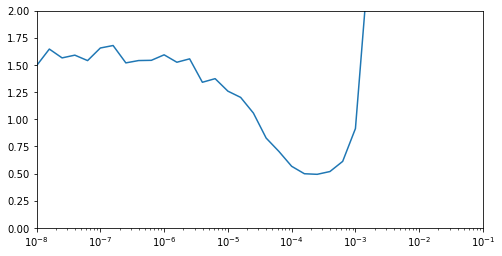

In [ ]:
plot_lr(model.history.history)

In [ ]:
find_lr(model.history.history)

max_lr = 3.981072e-05


{1.5848931e-08: -0.1525973081588745,
 2.5118863e-08: 0.08116936683654785,
 3.981072e-08: -0.025162220001220703,
 6.309573e-08: 0.050028324127197266,
 1e-07: -0.1158212423324585,
 1.5848931e-07: -0.022794604301452637,
 2.5118865e-07: 0.1597193479537964,
 3.9810718e-07: -0.02150118350982666,
 6.3095735e-07: -0.0020979642868041992,
 1e-06: -0.050595998764038086,
 1.5848932e-06: 0.06824398040771484,
 2.5118864e-06: -0.031196951866149902,
 3.9810716e-06: 0.21539652347564697,
 6.3095736e-06: -0.03323030471801758,
 1e-05: 0.11495590209960938,
 1.5848931e-05: 0.05741298198699951,
 2.5118865e-05: 0.14417827129364014,
 3.981072e-05: 0.23001128435134888,
 6.309574e-05: 0.12274301052093506,
 1e-04: 0.136860191822052,
 0.00015848932: 0.06842675805091858,
 0.00025118864: 0.005341857671737671,
 0.00039810716: -0.025567710399627686,
 0.00063095737: -0.09342342615127563,
 0.001: -0.30179834365844727}

### Bắt đầu lại

In [ ]:
max_lr = 3.981072e-05
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 80
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/80
18/18 [==============================] - 6s 184ms/step - loss: 1.9950 - accuracy: 0.5785 - f1: 0.5642 - val_loss: 1.6369 - val_accuracy: 0.7535 - val_f1: 0.7863
Epoch 2/80
18/18 [==============================] - 2s 122ms/step - loss: 1.2077 - accuracy: 0.8916 - f1: 0.9036 - val_loss: 1.2421 - val_accuracy: 0.8099 - val_f1: 0.8202
Epoch 3/80
18/18 [==============================] - 2s 128ms/step - loss: 0.8649 - accuracy: 0.9329 - f1: 0.9375 - val_loss: 1.4814 - val_accuracy: 0.7535 - val_f1: 0.7966
Epoch 4/80
18/18 [==============================] - 2s 129ms/step - loss: 0.7728 - accuracy: 0.9674 - f1: 0.9696 - val_loss: 1.1524 - val_accuracy: 0.8028 - val_f1: 0.8229
Epoch 5/80
18/18 [==============================] - 2s 127ms/step - loss: 0.6881 - accuracy: 0.9823 - f1: 0.9846 - val_loss: 1.2163 - val_accuracy: 0.7676 - val_f1: 0.8087
Epoch 6/80
18/18 [==============================] - 2s 128ms/step - loss: 0.6920 - accuracy: 0.9786 - f1: 0.9779 - val_loss: 1.0897 - val_ac

lable smoothing nếu chỉ thực hiện 1 mình thì kết quả không thực sự tốt hẳn. Chúng ta cần kết hợp vs các phương pháp khác để tăng kết quả của metrics.